The training process involved three different models trained on different subsets of the loan data. The first model was trained on the original loan data, excluding the new metric columns and joint application data. The second and third models were trained on the same data as the first model, but included the new metric columns and joint application data as one-hot encoded features.

All three models used a similar neural network architecture with three hidden layers of varying sizes and 30% dropout regularization after each layer. The models were trained using the mean squared logarithmic error loss function and the Adam optimizer.

The first model was trained for 10 epochs with a batch size of 128, while the second and third models were trained for 10 epochs with batch sizes of 64 and 32, respectively. The third model was the final model used for prediction and was trained on the entire dataset without validation.

The trained model was saved in a file named "loan_risk_model", and the data transformer used to preprocess the data was saved in a file named "data_transformer.joblib".

The DataFrame contains 2,260,701 observations and each observation has 151 variables.

In [5]:
import pandas as pd
data_row = pd.read_csv(
  "./accepted_2007_to_2018Q4.csv",
  low_memory=False,
)

data_row.shape

(2260701, 151)

In [6]:
data_row.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Total percentage of null values in the data
# (data_row.isnull().sum().sum())/(data_row.shape[0]*data_row.shape[1])

This code reads in the LCDataDictionary.xlsx file, which is a data dictionary that provides descriptions for each of the variables in the LendingClub loan dataset.
This is a helpful way to understand what each variable represents in the dataset.

In [9]:
variable_definitions = pd.read_excel("https://resources.lendingclub.com/LCDataDictionary.xlsx")

# Drop blank rows, strip white space, set the "LoanStatNew" column as the index, and converting the "Description" column to a Python dictionary.
variable_definitions.dropna(axis="index", inplace=True)
variable_definitions = variable_definitions.applymap(lambda x: x.strip())
variable_definitions.set_index("LoanStatNew", inplace=True)
dictionary = variable_definitions["Description"].to_dict()
# Rename "verified_status_joint" to "verification_status_joint".
dictionary["verification_status_joint"] = dictionary.pop("verified_status_joint")

# Print out each column name in the data_row and its corresponding description from the data dictionary
for col in data_row.columns:
  print(f"•{col}: {dictionary[col]}")

•id: A unique LC assigned ID for the loan listing.
•member_id: A unique LC assigned Id for the borrower member.
•loan_amnt: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
•funded_amnt: The total amount committed to that loan at that point in time.
•funded_amnt_inv: The total amount committed by investors for that loan at that point in time.
•term: The number of payments on the loan. Values are in months and can be either 36 or 60.
•int_rate: Interest Rate on the loan
•installment: The monthly payment owed by the borrower if the loan originates.
•grade: LC assigned loan grade
•sub_grade: LC assigned loan subgrade
•emp_title: The job title supplied by the Borrower when applying for the loan.*
•emp_length: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
•home_ownership: The home owner

Here are the descriptions of each of the columns:

term: The number of payments on the loan. Values are in months and can be either 36 or 60.
installment: The monthly payment owed by the borrower if the loan is funded.
total_rec_prncp: The total principal amount of the loan that has been paid off by the borrower.
total_rec_int: The total interest amount that has been paid by the borrower.
total_rec_late_fee: The total late fee amount that has been paid by the borrower.
recoveries: The post charge off gross recovery amount.
collection_recovery_fee: The post charge off collection fee.

Here is the formula we can use to calculate:

Expected Return = term x installment
Amount Received = total_rec_prncp + total_rec_int + total_rec_late_fee + recoveries - collection_recovery_fee
Fraction of Expected Return Recovered = Amount Received / Expected Return

In [10]:
output_columns = ["term", "installment", "total_rec_prncp", "total_rec_int", "total_rec_late_fee", "recoveries", "collection_recovery_fee"]

Some columns contain irrelevant demographic data or data that was not created until after a loan was accepted, and thus those columns need to be removed. The column "emp_title" (the applicant's job title) is potentially relevant in the context of a loan, but it has too many unique values to be useful. We can drop this column for now.

In [11]:
data_row["emp_title"].nunique()

512694

In [12]:
dropped_columns = ["id", "member_id", "funded_amnt", "funded_amnt_inv", "int_rate", "grade", "sub_grade", "emp_title", "pymnt_plan", "url", "desc", "title", "zip_code", "addr_state", "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt", "total_pymnt_inv", "last_pymnt_d", "last_pymnt_amnt", "next_pymnt_d", "last_credit_pull_d", "last_fico_range_high", "last_fico_range_low", "policy_code", "hardship_flag", "hardship_type", "hardship_reason", "hardship_status", "deferral_term", "hardship_amount", "hardship_start_date", "hardship_end_date", "payment_plan_start_date", "hardship_length", "hardship_dpd", "hardship_loan_status", "orig_projected_additional_accrued_interest", "hardship_payoff_balance_amount", "hardship_last_payment_amount", "disbursement_method", "debt_settlement_flag", "debt_settlement_flag_date", "settlement_status", "settlement_date", "settlement_amount", "settlement_percentage", "settlement_term"]
data = data_row.drop(columns=dropped_columns)

Group the data by the "loan_status" column, and then counts the number of occurrences of each unique value in the "loan_status" column

In [13]:
data.groupby("loan_status")["loan_status"].count()

loan_status
Charged Off                                             268559
Current                                                 878317
Default                                                     40
Does not meet the credit policy. Status:Charged Off        761
Does not meet the credit policy. Status:Fully Paid        1988
Fully Paid                                             1076751
In Grace Period                                           8436
Late (16-30 days)                                         4349
Late (31-120 days)                                       21467
Name: loan_status, dtype: int64

For practical purposes, we decide to only consider loans with statuses containing "Fully Paid" or "Charged Off" as these indicate the loan is no longer active. The "credit policy" columns were also merged with their matching status.

In [14]:
data["purpose"] = data["purpose"].replace("educational", "other")

In [15]:
credit_policy_related = "Does not meet the credit policy. Status:"
len_credit_policy_related = len(credit_policy_related)

def remove_credit_policy_related(status):
    if credit_policy_related in str(status):
        return status[len_credit_policy_related:]
    else:
        return status

data["loan_status"] = data["loan_status"].apply(remove_credit_policy_related)

rows_to_drop = data[(data["loan_status"] != "Charged Off") & (data["loan_status"] != "Fully Paid")].index
data.drop(index=rows_to_drop, inplace=True)

data.groupby("loan_status")["loan_status"].count()

loan_status
Charged Off     269320
Fully Paid     1078739
Name: loan_status, dtype: int64

<Axes: xlabel='loan_status', ylabel='count'>

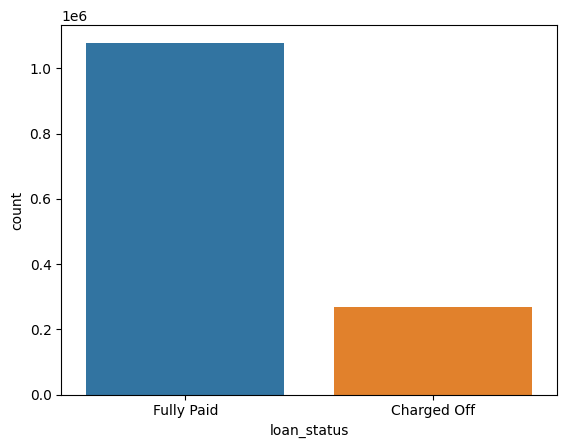

In [17]:
import seaborn as sns
sns.countplot(x='loan_status', data = data)

The plot shows a histogram of the loan amount distribution in the dataset. The x-axis represents the loan amount and the y-axis represents the count (or frequency) of loans in the corresponding loan amount bin. It appears that the majority of loans fall within the range of 0 to 40,000, with a peak around 10,000.

<Axes: xlabel='loan_amnt', ylabel='Count'>

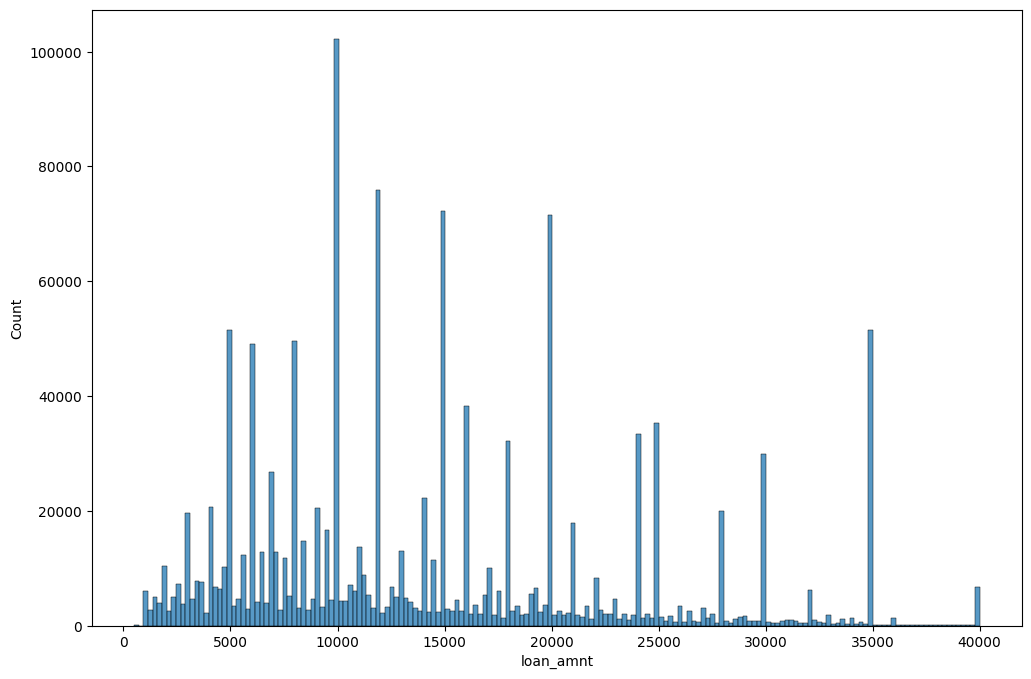

In [18]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (12,8))
sns.histplot(x='loan_amnt', data = data)

In [19]:
# import pandas as pd
#
# correlation_matrix = data.corr(numeric_only=True)
# # Display the correlation matrix
# print(correlation_matrix)

# A correlation matrix is a table showing the correlation coefficients between several variables. The values in the matrix range from -1 to 1 and show how strongly pairs of variables are related. A positive correlation means that as one variable increases, so does the other, while a negative correlation means that as one variable increases, the other decreases. A value of 0 indicates no correlation between the variables.

In [20]:
# import numpy as np
#
# # Define the threshold for high correlation
# threshold = 0.9
#
# # Find highly correlated pairs of columns
# corr_matrix = data.drop(columns=output_columns).corr().abs()
# upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# high_corr = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
# print(high_corr)
#
# # Drop highly correlated columns
# data.drop(high_corr, axis=1, inplace=True)

In [21]:
data[output_columns].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1348059 entries, 0 to 2260697
Data columns (total 7 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   term                     1348059 non-null  object 
 1   installment              1348059 non-null  float64
 2   total_rec_prncp          1348059 non-null  float64
 3   total_rec_int            1348059 non-null  float64
 4   total_rec_late_fee       1348059 non-null  float64
 5   recoveries               1348059 non-null  float64
 6   collection_recovery_fee  1348059 non-null  float64
dtypes: float64(6), object(1)
memory usage: 82.3+ MB


In [22]:
data.groupby("term")["term"].count()

term
 36 months    1023181
 60 months     324878
Name: term, dtype: int64

In [23]:
# Define a list of columns to one-hot encode
onehot_coloumns = ["term"]

# Strip leading/trailing whitespace from the term column
data["term"] = data["term"].map(lambda term_str: term_str.strip())

# Extract the numerical value from the term column and store it in a new column called term_num
extract_num = lambda term_str: float(term_str[:2])
data["term_num"] = data["term"].map(extract_num)

# Remove the original term column from the list of output columns and add the new term_num column
output_columns.remove("term")
output_columns.append("term_num")

In [24]:
received = data[["total_rec_prncp", "total_rec_int", "total_rec_late_fee", "recoveries"]].sum(axis=1) - data["collection_recovery_fee"]
expected = data["installment"] * data["term_num"]
data["recovered_percentage"] = received / expected

data.groupby("loan_status")["recovered_percentage"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,269320.0,0.400162,0.219020,0.000000,0.224463,0.367554,0.550924,2.410680
Fully Paid,1078739.0,0.932705,0.100455,0.506053,0.897912,0.960100,0.997612,60.932353


In [25]:
import numpy as np

# set a maximum value of 1 for the recovered_percentage variable
data["recovered_percentage"] = np.where(
  (data["loan_status"] == "Fully Paid") | (data["recovered_percentage"] > 1.0),
  1.0,
  data["recovered_percentage"],
)

# group the data by loan_status and describe the recovered_percentage variable
data.groupby("loan_status")["recovered_percentage"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,269320.0,0.400152,0.218971,0.0,0.224463,0.367554,0.550924,1.0
Fully Paid,1078739.0,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.0


In [ ]:
plt

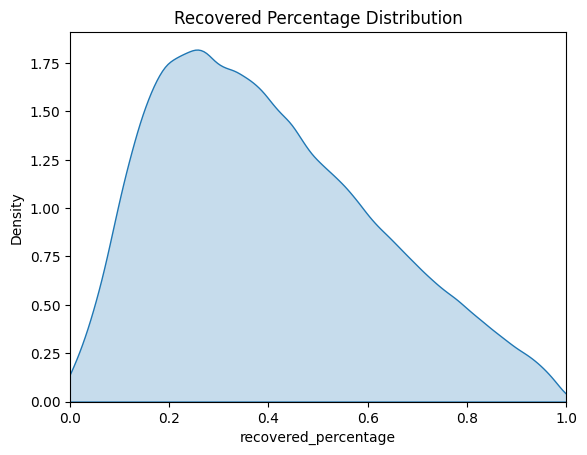

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.kdeplot(
  data=data["recovered_percentage"][data["loan_status"] == "Charged Off"],
  label="Charged Off",
  fill=True,
)
plt.axis(xmin=0, xmax=1)
plt.title('Recovered Percentage Distribution')
plt.show()

In [27]:
# The verbose parameter is set to True to show the counts of non-null values.
data.drop(columns=output_columns, inplace=True)
data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1348059 entries, 0 to 2260697
Data columns (total 97 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   loan_amnt                            1348059 non-null  float64
 1   term                                 1348059 non-null  object 
 2   emp_length                           1269514 non-null  object 
 3   home_ownership                       1348059 non-null  object 
 4   annual_inc                           1348055 non-null  float64
 5   verification_status                  1348059 non-null  object 
 6   issue_d                              1348059 non-null  object 
 7   loan_status                          1348059 non-null  object 
 8   purpose                              1348059 non-null  object 
 9   dti                                  1347685 non-null  float64
 10  delinq_2yrs                          1348030 non-null  float64
 11  ear

The columns with a high number of null values can be categorized into three groups:
1. derogatory/delinquency metrics, where null values indicate no such marks;
2. metrics applicable only to joint applications, where null values indicate a single application;
3. a group of 14 credit history-related columns with only 537,000 entries, which raises questions about their novelty.

Additionally, I will include "mths_since_recent_inq" in the first category since its non-null count falls below the threshold of complete data at around 1,277,783, and null values here may indicate no recent inquiries.

In [28]:
negative_mark_columns = ["mths_since_last_delinq", "mths_since_last_record", "mths_since_last_major_derog", "mths_since_recent_bc_dlq", "mths_since_recent_inq", "mths_since_recent_revol_delinq", "mths_since_recent_revol_delinq", "sec_app_mths_since_last_major_derog"]
joint_columns = ["annual_inc_joint", "dti_joint", "verification_status_joint", "revol_bal_joint", "sec_app_fico_range_low", "sec_app_fico_range_high", "sec_app_earliest_cr_line", "sec_app_inq_last_6mths", "sec_app_mort_acc", "sec_app_open_acc", "sec_app_revol_util", "sec_app_open_act_il", "sec_app_num_rev_accts", "sec_app_chargeoff_within_12_mths", "sec_app_collections_12_mths_ex_med", "sec_app_mths_since_last_major_derog"]
confusing_columns = ["open_acc_6m", "open_act_il", "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il", "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc", "all_util", "inq_fi", "total_cu_tl", "inq_last_12m"]

In [29]:
# Convert "issue_d" column to datetime format
data["issue_d"] = data["issue_d"].astype("datetime64[ns]")

# Check the date range of confusing columns by selecting the confusing columns and the "issue_d" column,
# removing rows with null values, and then computing the count, min and max values for "issue_d"
data[confusing_columns + ["issue_d"]].dropna(axis="index")["issue_d"].agg(
  ["count", "min", "max"]
)

/var/folders/d5/hpc31dsx59l4rfyrs6m6yvp00000gn/T/ipykernel_12728/2335218645.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["issue_d"] = data["issue_d"].astype("datetime64[ns]")


count                 464325
min      2015-12-01 00:00:00
max      2018-12-01 00:00:00
Name: issue_d, dtype: object

In [30]:
# # Assuming 'data' is a DataFrame containing your data
# # Make sure 'issue_d' is already converted to datetime format
#
# # Filter rows to only include data from 2018
# data = data[(data['issue_d'] >= np.datetime64("2015-01-01")) & (data['issue_d'] <= np.datetime64("2018-12-31"))]
#
# # Reset the index of the new DataFrame
# data.reset_index(drop=True, inplace=True)

In [31]:
# Filter the "issue_d" column to only include dates from Dec 2015 onward and get the count, minimum, and maximum date values
data["issue_d"][data["issue_d"] >= np.datetime64("2015-12-01")].agg(
  ["count", "min", "max"]
)

count                 557708
min      2015-12-01 00:00:00
max      2018-12-01 00:00:00
Name: issue_d, dtype: object

After examining the data, it appears that the 14 confusing columns are indeed newer metrics, and their usage only began in December 2015. However, even after that point, their usage is spotty. Despite this, I'm curious to see if these additional metrics would improve the accuracy of a machine learning model. So, after completing the data cleaning process, I will create a new dataset that contains only the rows with these new metrics and use it to build a new model that includes these metrics.

In [32]:
new_metric_columns = confusing_columns

To process the derogatory/delinquency metrics, I will follow Michael Wurm's suggestion and obtain the inverse of all the “months since recent/last” fields. This conversion will transform each field into a proxy for the frequency of the event, while allowing me to assign a 0 value to all the null fields (when an event has never occurred). For the “months since oldest” fields, I will set the null values to 0 and leave the remaining fields unchanged.

In [33]:
# Identify columns with "months since" and "months since recent" in their name
months_since_last_columns = [
    col_name for col_name in data.columns if "mths_since" in col_name or "mo_sin_rcnt" in col_name
]

# For "months since" columns, if the value is 0, set it to 1 to avoid dividing by zero. If the value is already a number of months, take the inverse.
for col_name in months_since_last_columns:
    data[col_name] = [
        0.0 if pd.isna(months) else 1 / 1 if months == 0 else 1 / months
        for months in data[col_name]
    ]

# Rename inverse columns
rename_mapper = {}
for col_name in months_since_last_columns:
    rename_mapper[col_name] = col_name.replace("mths_since", "inv_mths_since").replace(
        "mo_sin_rcnt", "inv_mo_sin_rcnt"
    )
data.rename(columns=rename_mapper, inplace=True)

# Identify columns with "months since oldest" in their name
months_since_oldest_columns = [
    col_name for col_name in data.columns if "mo_sin_old" in col_name
]

# Replace null values in "months since oldest" columns with 0
data.loc[:, months_since_oldest_columns].fillna(0, inplace=True)

def replace_list_value(l, old_value, new_value):
  i = l.index(old_value)
  l.pop(i)
  l.insert(i, new_value)

# Replace columns in new_metric_columns with their inverse values
replace_list_value(new_metric_columns, "mths_since_rcnt_il", "inv_mths_since_rcnt_il")
replace_list_value(
    joint_columns,
    "sec_app_mths_since_last_major_derog",
    "sec_app_inv_mths_since_last_major_derog",
)

Take a look at joint loans, it seems there are newer metrics for joint applications as well.

In [34]:
joint_loans = data[:][data["application_type"] == "Joint App"]
joint_loans[joint_columns].info()

<class 'pandas.core.frame.DataFrame'>
Index: 25800 entries, 2 to 2260663
Data columns (total 16 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   annual_inc_joint                         25800 non-null  float64
 1   dti_joint                                25797 non-null  float64
 2   verification_status_joint                25595 non-null  object 
 3   revol_bal_joint                          18629 non-null  float64
 4   sec_app_fico_range_low                   18630 non-null  float64
 5   sec_app_fico_range_high                  18630 non-null  float64
 6   sec_app_earliest_cr_line                 18630 non-null  object 
 7   sec_app_inq_last_6mths                   18630 non-null  float64
 8   sec_app_mort_acc                         18630 non-null  float64
 9   sec_app_open_acc                         18630 non-null  float64
 10  sec_app_revol_util                       18302 no

In [35]:
# List of columns with new metrics that only apply to joint applications
joint_new_metric_columns = ["revol_bal_joint", "sec_app_fico_range_low", "sec_app_fico_range_high", "sec_app_earliest_cr_line", "sec_app_inq_last_6mths", "sec_app_mort_acc", "sec_app_open_acc", "sec_app_revol_util", "sec_app_open_act_il", "sec_app_num_rev_accts", "sec_app_chargeoff_within_12_mths", "sec_app_collections_12_mths_ex_med", "sec_app_inv_mths_since_last_major_derog"]

# Check date range of joint loan data with new metrics
joint_loans[joint_new_metric_columns + ["issue_d"]].dropna(axis="index")["issue_d"].agg(
["count", "min", "max"]
)

count                  18301
min      2017-03-01 00:00:00
max      2018-12-01 00:00:00
Name: issue_d, dtype: object

In [36]:
joint_loans["issue_d"].agg(["count", "min", "max"])

count                  25800
min      2015-10-01 00:00:00
max      2018-12-01 00:00:00
Name: issue_d, dtype: object

In [37]:
# Adding "application_type" to the list of one-hot encoded columns.
onehot_coloumns.append("application_type")

# Looping through a list of column names that appear in both the joint application and individual application dataframes and replacing the joint application values with the individual application values for applications that are not joint.
for joint_col, indiv_col in zip(
        ["annual_inc_joint", "dti_joint", "verification_status_joint"],
        ["annual_inc", "dti", "verification_status"],
):
  data[joint_col] = [
    joint_val if app_type == "Joint App" else indiv_val
    for app_type, joint_val, indiv_val in zip(
      data["application_type"], data[joint_col], data[indiv_col]
    )
  ]

data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1348059 entries, 0 to 2260697
Data columns (total 97 columns):
 #   Column                                   Non-Null Count    Dtype         
---  ------                                   --------------    -----         
 0   loan_amnt                                1348059 non-null  float64       
 1   term                                     1348059 non-null  object        
 2   emp_length                               1269514 non-null  object        
 3   home_ownership                           1348059 non-null  object        
 4   annual_inc                               1348055 non-null  float64       
 5   verification_status                      1348059 non-null  object        
 6   issue_d                                  1348059 non-null  datetime64[ns]
 7   loan_status                              1348059 non-null  object        
 8   purpose                                  1348059 non-null  object        
 9   dti               

In [38]:
cols_to_search = [
  col for col in data.columns if col not in new_metric_columns + joint_new_metric_columns
]
data.dropna(axis="index", subset=cols_to_search).shape

(1110171, 97)

In [39]:
data.dropna(axis="index", subset=cols_to_search, inplace=True)

In [40]:
data[["earliest_cr_line", "sec_app_earliest_cr_line"]]

,earliest_cr_line,sec_app_earliest_cr_line
0,Aug-2003,NaN
1,Dec-1999,NaN
2,Aug-2000,NaN
4,Jun-1998,NaN
5,Oct-1987,NaN
...,...,...
2260688,Jul-2004,NaN
2260690,Mar-2002,NaN
2260691,Jun-2011,NaN
2260692,Aug-1997,NaN


In [41]:
def get_credit_history_age(col_name):
  earliest_cr_line_date = data[col_name].astype("datetime64[ns]")
  cr_hist_age_delta = data["issue_d"] - earliest_cr_line_date
  MINUTES_PER_MONTH = int(365.25 / 12 * 24 * 60)
  cr_hist_age_months = cr_hist_age_delta / np.timedelta64(MINUTES_PER_MONTH, "m")
  return cr_hist_age_months.map(
    lambda value: np.nan if pd.isna(value) else round(value)
  )


cr_hist_age_months = get_credit_history_age("earliest_cr_line")
cr_hist_age_months

/var/folders/d5/hpc31dsx59l4rfyrs6m6yvp00000gn/T/ipykernel_12728/995118449.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  earliest_cr_line_date = data[col_name].astype("datetime64[ns]")


0          148
1          192
2          184
4          210
5          338
          ... 
2260688    147
2260690    175
2260691     64
2260692    230
2260697    207
Length: 1110171, dtype: int64

In [42]:
data["earliest_cr_line"] = cr_hist_age_months
data["sec_app_earliest_cr_line"] = get_credit_history_age(
  "sec_app_earliest_cr_line"
).astype("Int64")
data.rename(
  columns={
    "earliest_cr_line": "cr_hist_age_mths",
    "sec_app_earliest_cr_line": "sec_app_cr_hist_age_mths",
  },
  inplace=True,
)
replace_list_value(
  joint_new_metric_columns, "sec_app_earliest_cr_line", "sec_app_cr_hist_age_mths"
)

/var/folders/d5/hpc31dsx59l4rfyrs6m6yvp00000gn/T/ipykernel_12728/995118449.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  earliest_cr_line_date = data[col_name].astype("datetime64[ns]")


In [43]:
categorical_cols = ["term", "emp_length", "home_ownership", "verification_status", "purpose", "verification_status_joint"]
for i, col_name in enumerate(categorical_cols):
  print(
    data.groupby(col_name)[col_name].count(),
    "\n" if i < len(categorical_cols) - 1 else "",
  )

term
36 months    831601
60 months    278570
Name: term, dtype: int64 

emp_length
1 year        76868
10+ years    392883
2 years      106124
3 years       93784
4 years       69031
5 years       72421
6 years       54240
7 years       52229
8 years       53826
9 years       45210
< 1 year      93555
Name: emp_length, dtype: int64 

home_ownership
ANY            250
MORTGAGE    559035
NONE            39
OTHER           40
OWN         114577
RENT        436230
Name: home_ownership, dtype: int64 

verification_status
Not Verified       335350
Source Verified    463153
Verified           311668
Name: verification_status, dtype: int64 

purpose
car                    10754
credit_card           245942
debt_consolidation    653222
home_improvement       71089
house                   5720
major_purchase         22901
medical                12302
moving                  7464
other                  60987
renewable_energy         691
small_business         11137
vacation                7169
we

In [44]:
data.drop(
  columns=[
    "verification_status",
    "verification_status_joint",
    "issue_d",
    "loan_status",
  ],
  inplace=True,
)

In [45]:
onehot_coloumns += ["home_ownership", "purpose"]
ordinal_cols = {
  "emp_length": [
    "< 1 year",
    "1 year",
    "2 years",
    "3 years",
    "4 years",
    "5 years",
    "6 years",
    "7 years",
    "8 years",
    "9 years",
    "10+ years",
  ]
}

In [46]:
data_final = data.drop(columns=new_metric_columns + joint_new_metric_columns)

In [47]:
query_df = data[["il_util", "total_bal_il", "total_il_high_credit_limit"]].dropna(
  axis="index", subset=["il_util"]
)
query_df["il_util_compute"] = (
        query_df["total_bal_il"] / query_df["total_il_high_credit_limit"]
).map(lambda x: float(round(x * 100)))
query_df[["il_util", "il_util_compute"]]

,il_util,il_util_compute
0,36.0,36.0
1,73.0,73.0
2,73.0,73.0
4,84.0,84.0
5,99.0,99.0
...,...,...
2260688,52.0,39.0
2260690,50.0,74.0
2260691,47.0,47.0
2260692,79.0,79.0


In [48]:
(query_df["il_util"] == query_df["il_util_compute"]).describe()

count     408722
unique         2
top         True
freq      307589
dtype: object

In [49]:
query_df["compute_diff"] = abs(query_df["il_util"] - query_df["il_util_compute"])
query_df["compute_diff"][query_df["compute_diff"] != 0].describe()

count    101133.000000
mean         14.638684
std          16.409913
min           1.000000
25%           3.000000
50%          10.000000
75%          21.000000
max        1108.000000
Name: compute_diff, dtype: float64

In [50]:
data["il_util_imputed"] = [
  True if pd.isna(util) & pd.notna(bal) & pd.notna(limit) else False
  for util, bal, limit in zip(
    data["il_util"], data["total_bal_il"], data["total_il_high_credit_limit"]
  )
]
new_metric_onehot_coloumns = ["il_util_imputed"]
data["il_util"] = [
  0.0
  if pd.isna(util) & pd.notna(bal) & (limit == 0)
  else float(round(bal / limit * 100))
  if pd.isna(util) & pd.notna(bal) & pd.notna(limit)
  else util
  for util, bal, limit in zip(
    data["il_util"], data["total_bal_il"], data["total_il_high_credit_limit"]
  )
]

In [52]:
from sklearn.model_selection import train_test_split
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout


def run_pipeline(
        data, onehot_coloumns, ordinal_cols, batch_size, validate=True,
):
  X = data.drop(columns=["recovered_percentage"])
  y = data["recovered_percentage"]
  X_train, X_valid, y_train, y_valid = (
    train_test_split(X, y, test_size=0.2, random_state=0)
    if validate
    else (X, None, y, None)
  )

  transformer = DataFrameMapper(
    [
      (onehot_coloumns, OneHotEncoder(drop="if_binary")),
      (
        list(ordinal_cols.keys()),
        OrdinalEncoder(categories=list(ordinal_cols.values())),
      ),
    ],
    default=StandardScaler(),
  )

  X_train = transformer.fit_transform(X_train)
  X_valid = transformer.transform(X_valid) if validate else None

  input_nodes = X_train.shape[1]
  output_nodes = 1

  model = Sequential()
  model.add(Input((input_nodes,)))
  model.add(Dense(64, activation="relu"))
  model.add(Dropout(0.3, seed=0))
  model.add(Dense(32, activation="relu"))
  model.add(Dropout(0.3, seed=1))
  model.add(Dense(16, activation="relu"))
  model.add(Dropout(0.3, seed=2))
  model.add(Dense(output_nodes))
  model.compile(optimizer="adam", loss="mean_squared_logarithmic_error")

  history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=10,
    validation_data=(X_valid, y_valid) if validate else None,
    verbose=1,
  )

  return history.history, model, transformer


print("Model Result:")
history, final_model, final_transformer = run_pipeline(
    data_final, onehot_coloumns, ordinal_cols, batch_size=128,
)

2023-04-19 11:42:53.153507: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model Result:
Epoch 1/10
6939/6939 [==============================] - 16s 2ms/step - loss: 0.0275 - val_loss: 0.0235
Epoch 2/10
6939/6939 [==============================] - 14s 2ms/step - loss: 0.0234 - val_loss: 0.0233
Epoch 3/10
6939/6939 [==============================] - 15s 2ms/step - loss: 0.0233 - val_loss: 0.0232
Epoch 4/10
6939/6939 [==============================] - 16s 2ms/step - loss: 0.0233 - val_loss: 0.0232
Epoch 5/10
6939/6939 [==============================] - 16s 2ms/step - loss: 0.0232 - val_loss: 0.0233
Epoch 6/10
6939/6939 [==============================] - 14s 2ms/step - loss: 0.0232 - val_loss: 0.0232
Epoch 7/10
6939/6939 [==============================] - 14s 2ms/step - loss: 0.0232 - val_loss: 0.0231
Epoch 8/10
6939/6939 [==============================] - 14s 2ms/step - loss: 0.0232 - val_loss: 0.0230
Epoch 9/10
6939/6939 [==============================] - 14s 2ms/step - loss: 0.0232 - val_loss: 0.0229
Epoch 10/10
6939/6939 [==============================] - 14

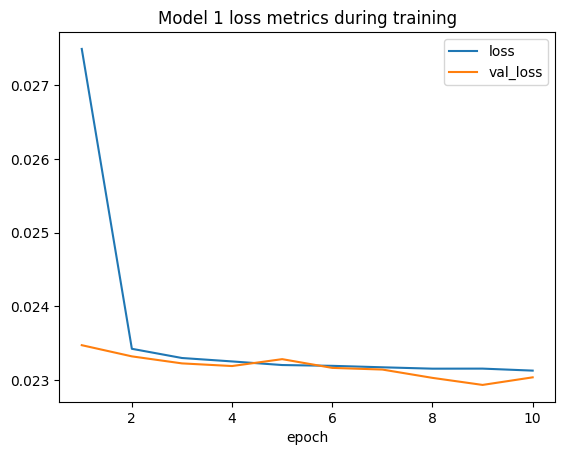

In [53]:
sns.lineplot(x=range(1, 11), y=history["loss"], label="loss")
sns.lineplot(x=range(1, 11), y=history["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.title("Model 1 loss metrics during training")
plt.show()

In [57]:
import joblib

final_model.save("loan_risk_model")
joblib.dump(final_transformer, "data_transformer.joblib")

2023-04-19 11:48:00.788610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-04-19 11:48:00.803616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-04-19 11:48:00.820538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16]
	 [[{{node inputs}}]]
2023-04-19 11:48:01

INFO:tensorflow:Assets written to: loan_risk_model/assets


INFO:tensorflow:Assets written to: loan_risk_model/assets


['data_transformer.joblib']

In [58]:
# Exports for "Can I Grade Loans Better than LendingClub?"
expected.rename("expected_return", inplace=True)
data_for_eval = data_final.join([data_row[["issue_d", "grade", "sub_grade"]], expected])
joblib.dump(data_for_eval, "data_for_eval.joblib")
#
# # Exports for "Improving Loan Risk Prediction With Natural Language Processing"
# data_for_nlp = data_final.join(data_row[["issue_d", "title", "desc"]])
# joblib.dump(data_for_nlp, "data_for_nlp.joblib")

['data_for_eval.joblib']